In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Data Analysis

In [3]:
# Connect SQLite.
dbconn = sqlite3.connect('../data/IowaLiquorSales.db')
cursor = dbconn.cursor()

# Pull Store database.
query = '''SELECT Sales.Date, Sales.ProductID, Product.CategoryGroup, Sales.VendorID, Product.Proof, Sales.StoreID, Sales.VolumeSold_Liters, Sales.Sale_Dollars, Price.StateBottleRetail
              FROM ((Sales 
              INNER JOIN Product ON Sales.ProductID=Product.ProductID)
              INNER JOIN Price ON Sales.ProductID=Price.ProductID and Sales.Date=Price.Date)
              WHERE Sales.Date BETWEEN '2019-01-01' AND '2019-12-31';'''
cursor.execute(query)
result = cursor.fetchall()
cursor.close()
dbconn.close()

In [4]:
# Put the database in a data frame format.
temp = pd.DataFrame(result, columns = ['Date',
                                            'ProductID',
                                            'CategoryGroup',
                                            'VendorID',
                                            'Proof',
                                            'StoreID',
                                            'VolumeSold_Gallons',
                                            'Sale_Dollars',
                                            'StateBottleRetail'])

In [5]:
temp.head()

,Date,ProductID,CategoryGroup,VendorID,Proof,StoreID,VolumeSold_Gallons,Sale_Dollars,StateBottleRetail
0,2019-03-19,26826,whisky,85,80.0,2513,18.00,560.64,23.36
1,2019-05-15,86251,liqueur,434,30.0,5068,12.00,43.56,3.63
2,2019-05-16,89566,tequila,55,80.0,2588,0.75,19.89,19.89
3,2019-05-15,35926,vodka,297,80.0,2647,9.00,60.72,5.06
4,2019-05-14,42699,rum,370,42.0,5202,2.25,33.72,11.24


In [6]:
temp.shape[0]

2380344

In [7]:
temp['Date'].min()

'2019-01-02'

In [8]:
temp['Date'].max()

'2019-12-31'

Text(0, 0.5, 'Product Sold')

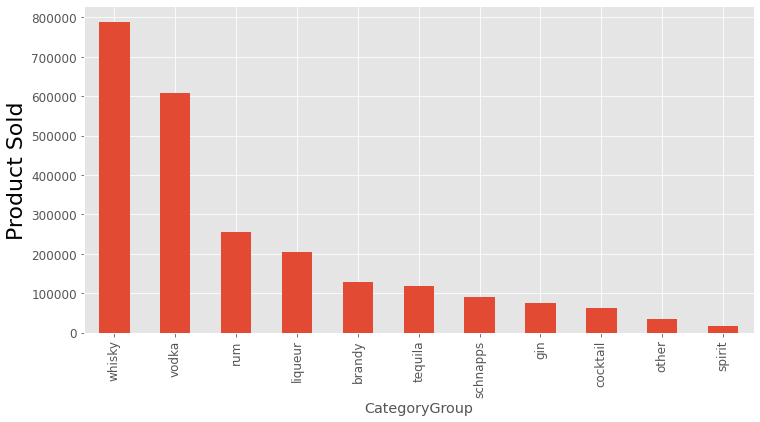

In [9]:
fig = plt.figure(figsize = (12,6))
temp.groupby('CategoryGroup').size().sort_values(ascending=False).plot.bar()

plt.ylabel('Product Sold',fontsize=22, color = 'black')

# Store Density by County

In [10]:
# Connect SQLite.
dbconn = sqlite3.connect('../data/IowaLiquorSales.db')
cursor = dbconn.cursor()

# Pull Store database.
query = '''SELECT Sales.TransactionID, Sales.Date, Sales.StoreID, Sales.ProductID, Store.County, Store.lat, Store.lng, County.Year, County.Population, County.UNEMPLOYMENT_RATE
              FROM ((Sales 
              INNER JOIN Store ON Sales.StoreID=Store.StoreID)
              INNER JOIN County ON Store.County=County.County)
              WHERE Sales.Date BETWEEN '2019-01-01' AND '2019-12-31' 
              AND County.Year = '2019';'''
cursor.execute(query)
result1 = cursor.fetchall()
cursor.close()
dbconn.close()

In [11]:
# Put the database in a data frame format.
temp1 = pd.DataFrame(result1, columns = ['TransactionID',
                                            'Date',
                                            'StoreID',
                                            'ProductID',
                                            'County',
                                            'lat',
                                            'lng','Year','Population','Unemployment_Rate'])

In [12]:
temp1.head()

,TransactionID,Date,StoreID,ProductID,County,lat,lng,Year,Population,Unemployment_Rate
0,INV-18212400042,2019-03-19,2513,26826,johnson,41.65143,-91.50105,2019,152480,2.4
1,INV-19392400209,2019-05-15,5068,86251,dickinson,43.36136,-95.13954,2019,17290,2.5
2,INV-19405700109,2019-05-16,2588,89566,linn,41.97518,-91.60977,2019,227241,3.1
3,INV-19379800083,2019-05-15,2647,35926,linn,41.93023,-91.71520,2019,227241,3.1
4,INV-19363000015,2019-05-14,5202,42699,black hawk,42.42449,-92.21869,2019,131089,3.7


In [13]:
county = pd.read_csv('../data/county.csv')
county.rename(columns={'UNEMPLOYMENT RATE': 'UNEMPLOYMENT_RATE'}, inplace=True)
county_2019 = county.loc[county['Year']==2019]
county_2019.head()

,County,Year,Population,Income_PerCapita,LABORFORCE,EMPLOYMENT,UNEMPLOYMENT,UNEMPLOYMENT_RATE
891,adair,2019,7102,51911.0,4370,4280,100,2.2
892,adams,2019,3602,57401.0,2250,2210,40,1.8
893,allamakee,2019,13671,48046.0,7430,7220,210,2.9
894,appanoose,2019,12525,38918.0,6170,5930,240,3.9
895,audubon,2019,5491,51186.0,3160,3080,80,2.5


In [14]:
StoreCount_temp = temp1.groupby(['County'])['StoreID'].nunique().sort_values(ascending=False).to_frame(name='Store_Count').reset_index()
StoreCount_temp.head()

,County,Store_Count
0,polk,223
1,linn,120
2,black hawk,84
3,scott,83
4,johnson,72


In [15]:
StoreCount = StoreCount_temp.merge(county_2019, on = ['County'], how = 'left')
StoreCount['StoresPer10K'] = (StoreCount['Store_Count']/StoreCount['Population'])*10000
StoreCount.head()

,County,Store_Count,Year,Population,Income_PerCapita,LABORFORCE,EMPLOYMENT,UNEMPLOYMENT,UNEMPLOYMENT_RATE,StoresPer10K
0,polk,223,2019,491031,54049.0,277700,269600,8100,2.9,4.541465
1,linn,120,2019,227241,53578.0,125600,121700,3900,3.1,5.280737
2,black hawk,84,2019,131089,46103.0,70300,67700,2600,3.7,6.407860
3,scott,83,2019,173400,55094.0,92800,89700,3100,3.3,4.786621
4,johnson,72,2019,152480,54769.0,88600,86500,2100,2.4,4.721931


In [16]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [17]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


cmap = plt.get_cmap('magma_r')
new_cmap = truncate_colormap(cmap, 0, 0.6)

In [18]:
# County Boundaries Shape File
map_counties = gpd.read_file(
    '../data/County_Boundaries_of_Iowa/geo_export_b0962504-4b8e-4a81-9f03-586d790445ed.shp')

map_counties.rename(columns={'county_nam': 'County'}, inplace=True)
map_counties["County"] = map_counties["County"].str.upper()
map_counties = map_counties.sort_values(by=['County'])

map_counties['County'] = map_counties['County'].str.lower()

In [19]:
map_counties.head()

,gnis_featu,fips,state_coun,County,acres,geometry
71,465190,19001,01,adair,364794.8,"POLYGON ((-94.70051 41.50434, -94.68163 41.504..."
80,465191,19003,02,adams,272218.7,"POLYGON ((-94.92751 41.15872, -94.91078 41.158..."
5,465192,19005,03,allamakee,421810.2,"POLYGON ((-91.61075 43.50060, -91.61061 43.500..."
97,465193,19007,04,appanoose,330047.6,"POLYGON ((-93.09759 40.89823, -93.07897 40.898..."
58,465194,19009,05,audubon,283755.1,"POLYGON ((-95.09285 41.86336, -95.07302 41.863..."


In [20]:
map_counties.loc[map_counties['County']=="obrien",'County']="o'brien"

In [21]:
# Digging into the discrepancies 
temp2 = list(map_counties['County'].unique())
temp1 = list(StoreCount['County'].unique())
s = set(temp2)
temp3 = [x for x in temp1 if x not in s]
temp3

[]

In [22]:
map_counties2 = map_counties.merge(StoreCount, on = ['County'], how = 'left')
map_counties2.head()

,gnis_featu,fips,state_coun,County,acres,geometry,Store_Count,Year,Population,Income_PerCapita,LABORFORCE,EMPLOYMENT,UNEMPLOYMENT,UNEMPLOYMENT_RATE,StoresPer10K
0,465190,19001,01,adair,364794.8,"POLYGON ((-94.70051 41.50434, -94.68163 41.504...",6,2019,7102,51911.0,4370,4280,100,2.2,8.448324
1,465191,19003,02,adams,272218.7,"POLYGON ((-94.92751 41.15872, -94.91078 41.158...",2,2019,3602,57401.0,2250,2210,40,1.8,5.552471
2,465192,19005,03,allamakee,421810.2,"POLYGON ((-91.61075 43.50060, -91.61061 43.500...",8,2019,13671,48046.0,7430,7220,210,2.9,5.851803
3,465193,19007,04,appanoose,330047.6,"POLYGON ((-93.09759 40.89823, -93.07897 40.898...",9,2019,12525,38918.0,6170,5930,240,3.9,7.185629
4,465194,19009,05,audubon,283755.1,"POLYGON ((-95.09285 41.86336, -95.07302 41.863...",4,2019,5491,51186.0,3160,3080,80,2.5,7.284648


No handles with labels found to put in legend.


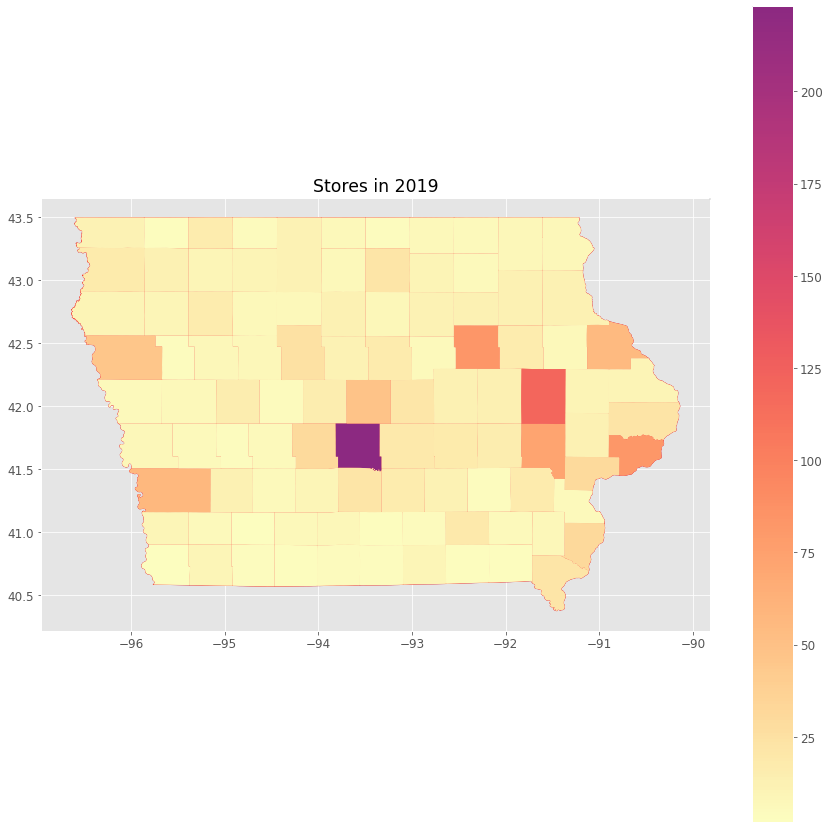

In [23]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

ax.set_title('Stores in 2019')

map_counties.plot(color='white', edgecolor='red', ax=ax)
map_counties2.plot(column='Store_Count', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

No handles with labels found to put in legend.


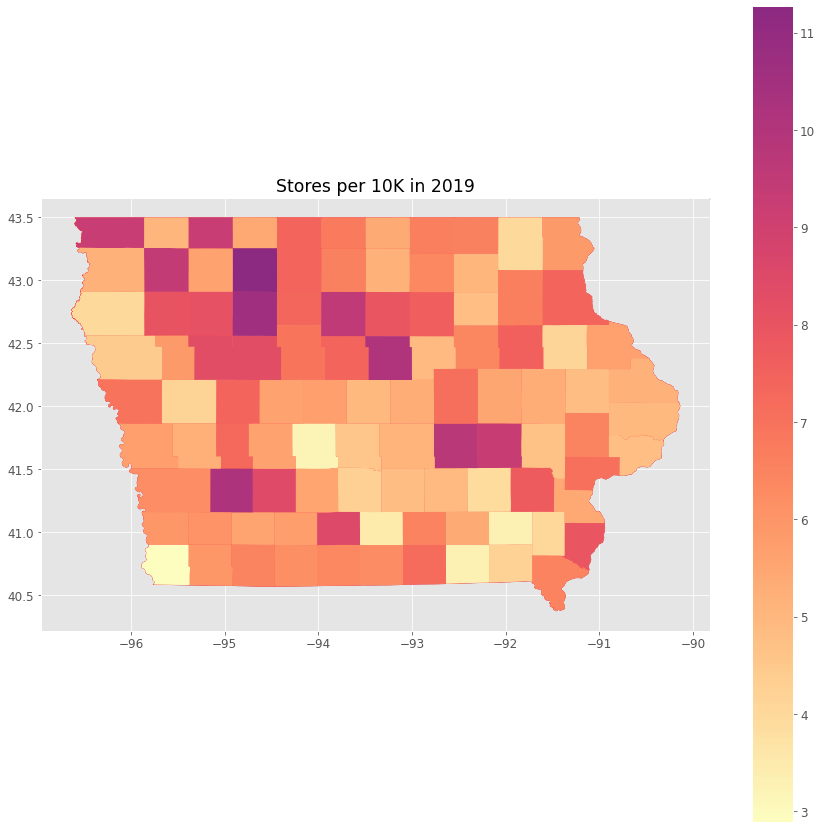

In [24]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

ax.set_title('Stores per 10K in 2019')

map_counties.plot(color='white', edgecolor='red', ax=ax)
map_counties2.plot(column='StoresPer10K', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

# Store Information???

In [25]:
# Connect SQLite.
dbconn = sqlite3.connect('../data/IowaLiquorSales.db')
cursor = dbconn.cursor()

# Pull Store database.
query = '''SELECT Sales.TransactionID, Sales.Date, Sales.StoreID, Store.StoreType, Sales.ProductID, Store.County, Store.lat, Store.lng
              FROM (Sales 
              INNER JOIN Store ON Sales.StoreID=Store.StoreID)
              WHERE Sales.Date BETWEEN '2019-01-01' AND '2019-12-31';'''
cursor.execute(query)
result2 = cursor.fetchall()
cursor.close()
dbconn.close()

In [26]:
# Put the database in a data frame format.
temp2 = pd.DataFrame(result2, columns = ['TransactionID',
                                            'Date',
                                            'StoreID',
                                            'StoreType',
                                            'ProductID',
                                            'County',
                                            'lat',
                                            'lng'])

In [27]:
temp2.head()

,TransactionID,Date,StoreID,StoreType,ProductID,County,lat,lng
0,INV-18212400042,2019-03-19,2513,Food/General Store,26826,johnson,41.65143,-91.50105
1,INV-19392400209,2019-05-15,5068,General Store,86251,dickinson,43.36136,-95.13954
2,INV-19405700109,2019-05-16,2588,Drugstore,89566,linn,41.97518,-91.60977
3,INV-19379800083,2019-05-15,2647,General Store,35926,linn,41.93023,-91.71520
4,INV-19363000015,2019-05-14,5202,General Store,42699,black hawk,42.42449,-92.21869


In [28]:
temp2['StoreID'].nunique()

1748